### Analyzing the Relationship Between Recipe Ingredients, Categories, Nutritional Values, and User Ratings

**Data preprocessing**

In [40]:
# %pip install opendatasets
import opendatasets as od 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# od.download("https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/data")

In [2]:
recipes = pd.read_csv('food-com-recipes-and-user-interactions/RAW_recipes.csv')
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [3]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [4]:
recipes.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

The only column with significant missing value is description.

In [5]:
reviews = pd.read_csv('food-com-recipes-and-user-interactions/RAW_interactions.csv')
reviews.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [7]:
reviews.isnull().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

The missing value in the review column is because some users leave ratings without writing a review.

We merge the two datasets together on recipe id

In [8]:
#Renaming ID -> Recipe_ID
recipes = recipes.rename(columns = {'id': 'recipe_id'})

#Nutrition values are evaluated as expression
recipes['nutrition'] = recipes['nutrition'].apply(eval)

#Distributing Values of Nutrition List to 7 New Detailed Columns
nutrition_columns = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
recipes[nutrition_columns] = pd.DataFrame(recipes['nutrition'].tolist(), index = recipes.index)

#Removing Nutrition Column
recipes = recipes.drop(['nutrition'], axis=1)

#Dropping Duplicates
recipes = recipes.drop_duplicates()

In [9]:
recipes_filtered = recipes.copy()
#Removing any rows where calories, minutes, n_ingredients, and n_steps are 0
recipes_filtered = recipes_filtered[(recipes_filtered['calories'] != 0) &
                                          (recipes_filtered['minutes'] != 0) &
                                          (recipes_filtered['n_steps'] != 0)]

#Removing the rows where all nutritional values are 0 simultaneously
recipes_filtered = recipes_filtered[(recipes_filtered[nutrition_columns] != 0).any(axis = 1)]
recipes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230489 entries, 0 to 231636
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 230488 non-null  object 
 1   recipe_id            230489 non-null  int64  
 2   minutes              230489 non-null  int64  
 3   contributor_id       230489 non-null  int64  
 4   submitted            230489 non-null  object 
 5   tags                 230489 non-null  object 
 6   n_steps              230489 non-null  int64  
 7   steps                230489 non-null  object 
 8   description          226175 non-null  object 
 9   ingredients          230489 non-null  object 
 10  n_ingredients        230489 non-null  int64  
 11  calories             230489 non-null  float64
 12  total fat (PDV)      230489 non-null  float64
 13  sugar (PDV)          230489 non-null  float64
 14  sodium (PDV)         230489 non-null  float64
 15  protein (PDV)        2

In [10]:
#Finding the numerical columns
numerical_columns = recipes.select_dtypes(include = ['number']).drop(['recipe_id','contributor_id'], axis = 1).columns.tolist()

#Calculating the 25th and 75th percentiles of all numerical columns to compute the IQR
Q1 = recipes_filtered[numerical_columns].quantile(0.25)
Q3 = recipes_filtered[numerical_columns].quantile(0.75)

#Calculating IQR for each column
IQR = Q3 - Q1

#Defining the upper limit as 1.5 times the IQR above Q3
upper_limit = Q3 + 1.5 * IQR

#Filtering out recipes with values above the upper limit for outlier handling
for col in numerical_columns:
    recipes_filtered = recipes_filtered[~(recipes_filtered[col] > upper_limit[col])]
recipes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158826 entries, 0 to 231636
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 158826 non-null  object 
 1   recipe_id            158826 non-null  int64  
 2   minutes              158826 non-null  int64  
 3   contributor_id       158826 non-null  int64  
 4   submitted            158826 non-null  object 
 5   tags                 158826 non-null  object 
 6   n_steps              158826 non-null  int64  
 7   steps                158826 non-null  object 
 8   description          155932 non-null  object 
 9   ingredients          158826 non-null  object 
 10  n_ingredients        158826 non-null  int64  
 11  calories             158826 non-null  float64
 12  total fat (PDV)      158826 non-null  float64
 13  sugar (PDV)          158826 non-null  float64
 14  sodium (PDV)         158826 non-null  float64
 15  protein (PDV)        1

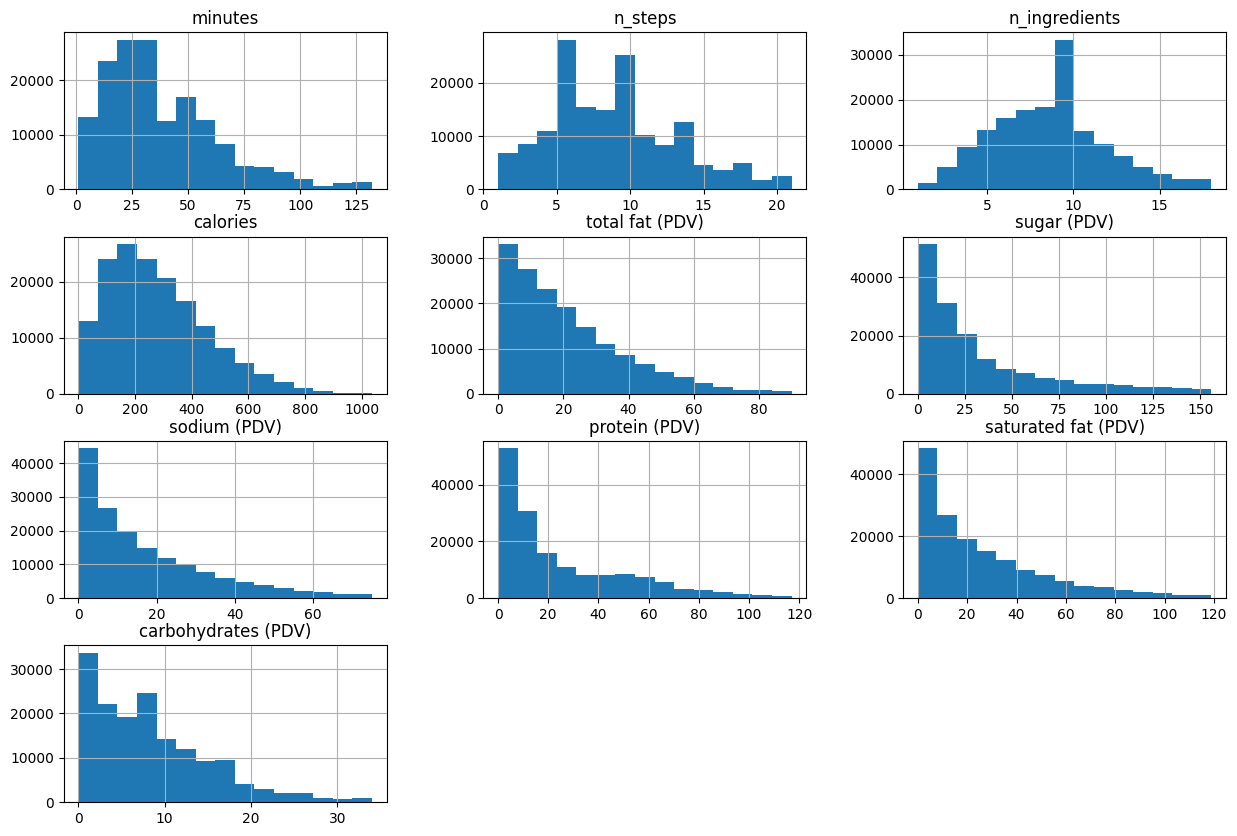

In [11]:
recipes_filtered.drop(['recipe_id','contributor_id'], axis = 1).hist(bins = 15, figsize = (15, 10))
# plt.savefig('recipes_filtered.png')
plt.show()

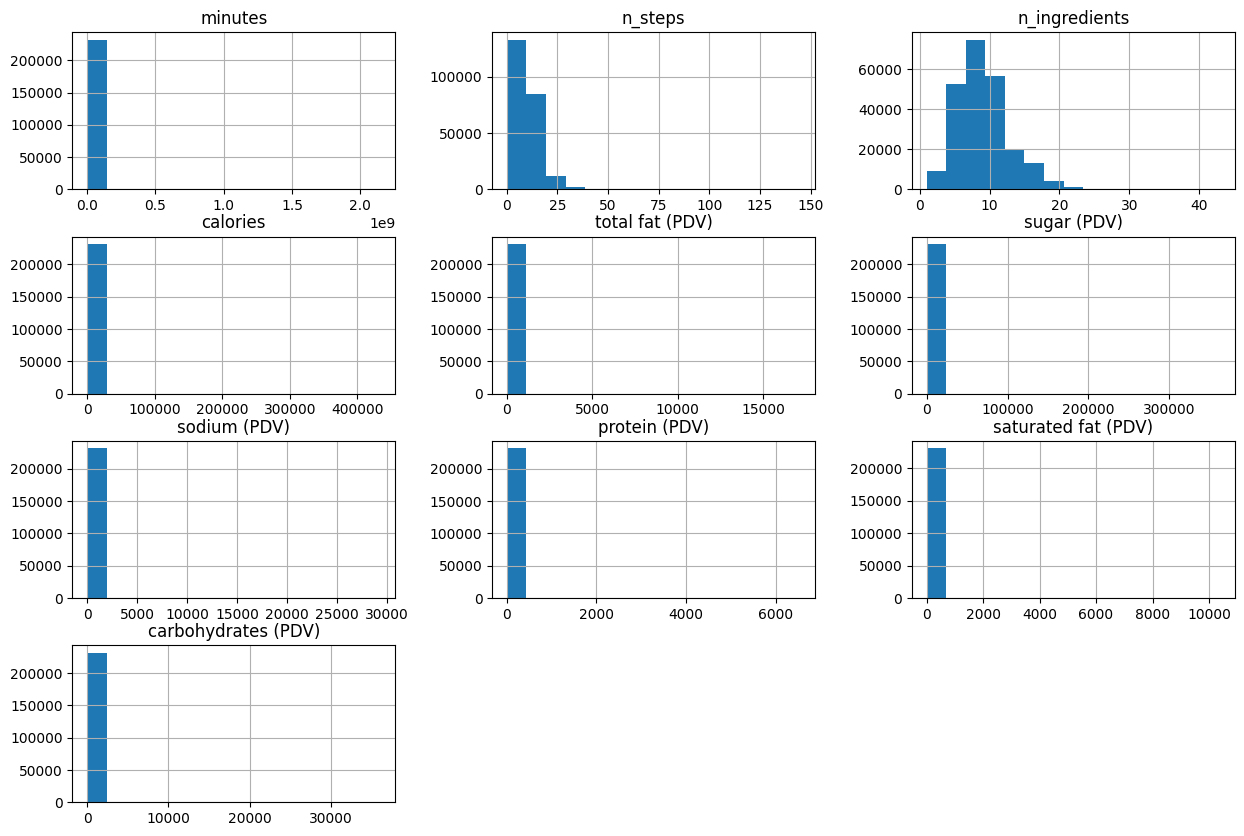

In [12]:
recipes.drop(['recipe_id','contributor_id'], axis = 1).hist(bins = 15, figsize = (15, 10))
# plt.savefig('recipes.png')
plt.show()

In [13]:
pd.options.display.float_format = '{:.2f}'.format
recipes.drop(['recipe_id','contributor_id'], axis = 1).describe()

,minutes,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,231637.00,231637.00,231637.00,231637.00,231637.00,231637.00,231637.00,231637.00,231637.00,231637.00
mean,9398.55,9.77,9.05,473.94,36.08,84.30,30.15,34.68,45.59,15.56
std,4461963.04,6.00,3.73,1189.71,77.80,800.08,131.96,58.47,98.24,81.82
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,20.00,6.00,6.00,174.40,8.00,9.00,5.00,7.00,7.00,4.00
50%,40.00,9.00,9.00,313.40,20.00,25.00,14.00,18.00,23.00,9.00
75%,65.00,12.00,11.00,519.70,41.00,68.00,33.00,51.00,52.00,16.00
max,2147483647.00,145.00,43.00,434360.20,17183.00,362729.00,29338.00,6552.00,10395.00,36098.00


In [14]:
recipes_filtered.info()
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158826 entries, 0 to 231636
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 158826 non-null  object 
 1   recipe_id            158826 non-null  int64  
 2   minutes              158826 non-null  int64  
 3   contributor_id       158826 non-null  int64  
 4   submitted            158826 non-null  object 
 5   tags                 158826 non-null  object 
 6   n_steps              158826 non-null  int64  
 7   steps                158826 non-null  object 
 8   description          155932 non-null  object 
 9   ingredients          158826 non-null  object 
 10  n_ingredients        158826 non-null  int64  
 11  calories             158826 non-null  float64
 12  total fat (PDV)      158826 non-null  float64
 13  sugar (PDV)          158826 non-null  float64
 14  sodium (PDV)         158826 non-null  float64
 15  protein (PDV)        1

In [15]:
reviews.describe()

,user_id,recipe_id,rating
count,1132367.00,1132367.00,1132367.00
mean,138429067.43,160897.21,4.41
std,501426863.68,130398.72,1.26
min,1533.00,38.00,0.00
25%,135470.00,54257.00,4.00
50%,330937.00,120547.00,5.00
75%,804550.00,243852.00,5.00
max,2002372706.00,537716.00,5.00


In [16]:
print('The reviews dataset has', reviews['recipe_id'].nunique(), 'unique recipes,',
      reviews['user_id'].nunique(), 'unique users and', reviews['rating'].nunique(), 'unique ratings.')

The reviews dataset has 231637 unique recipes, 226570 unique users and 6 unique ratings.


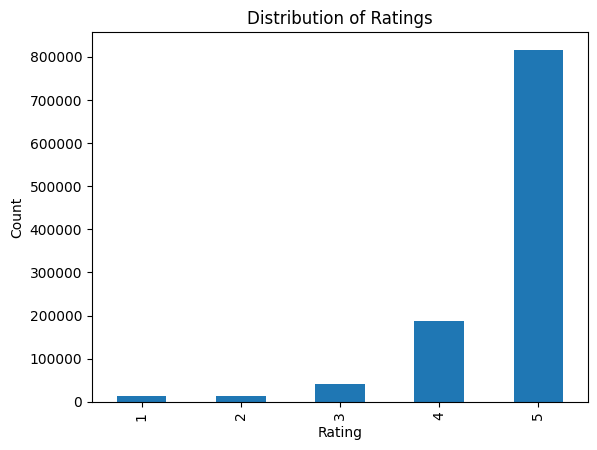

In [17]:
reviews_filtered = reviews[reviews['rating'] != 0]
reviews_filtered['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('ratings.png')
plt.show()

In [18]:
print('The filtered reviews dataset has', reviews_filtered['recipe_id'].nunique(), 'unique recipes,',
      reviews_filtered['user_id'].nunique(), 'unique users and', reviews_filtered['rating'].nunique(), 'unique ratings.')

The filtered reviews dataset has 226590 unique recipes, 196098 unique users and 5 unique ratings.


In [19]:
merged = pd.merge(recipes_filtered, reviews_filtered, on = 'recipe_id', how = 'inner')
merged.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),user_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",...,0.00,13.00,0.00,2.00,0.00,4.00,4470,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",...,0.00,13.00,0.00,2.00,0.00,4.00,593927,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",...,0.00,13.00,0.00,2.00,0.00,4.00,178427,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",...,18.00,0.00,17.00,22.00,35.00,1.00,346277,2006-08-27,5,This recipe was wonderful. Instead of using t...
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",...,18.00,0.00,17.00,22.00,35.00,1.00,319943,2009-07-18,4,"We liked this, but the I only baked for 15 min..."


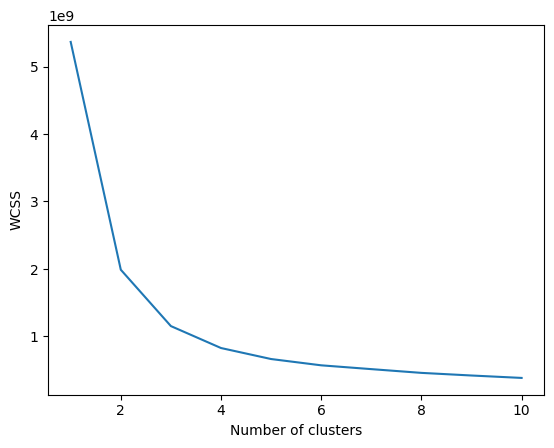

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

nutrition = recipes_filtered[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']]
scaler = StandardScaler()
scaled_nutrition = scaler.fit_transform(nutrition)

wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(nutrition) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss) 
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('wcss.png')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled_nutrition)
centroids = kmeans.cluster_centers_

recipes_filtered['Cluster'] = clusters
recipes_filtered.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),Cluster
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.50,0.00,13.00,0.00,2.00,0.00,4.00,1
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.40,18.00,0.00,17.00,22.00,35.00,1.00,1
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.80,22.00,32.00,48.00,39.00,27.00,5.00,2
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.10,17.00,10.00,2.00,14.00,8.00,20.00,0
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,380.70,53.00,7.00,24.00,6.00,24.00,6.00,2


In [22]:
recipes_filtered[recipes_filtered["Cluster"] == 0].describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),Cluster
count,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00,30482.00
mean,222914.64,40.52,5071136.08,9.05,8.71,314.28,18.07,87.02,10.91,14.64,23.27,14.60,0.00
std,139405.94,26.52,95341536.06,4.45,3.28,111.21,12.57,37.33,10.96,13.92,20.68,5.54,0.00
min,45.00,1.00,27.00,1.00,1.00,85.90,0.00,0.00,0.00,0.00,0.00,3.00,0.00
25%,103706.50,20.00,58104.00,6.00,6.00,231.70,9.00,63.00,3.00,6.00,7.00,10.00,0.00
50%,209627.50,35.00,182010.00,9.00,9.00,305.90,17.00,88.00,8.00,10.00,18.00,13.00,0.00
75%,333429.75,60.00,419005.25,12.00,11.00,383.90,25.00,115.00,15.00,19.00,35.00,18.00,0.00
max,537319.00,132.00,2002170767.00,21.00,18.00,994.60,87.00,156.00,75.00,116.00,119.00,34.00,0.00


In [23]:
recipes_filtered[recipes_filtered["Cluster"] == 2].head(20)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),Cluster
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.80,22.00,32.00,48.00,39.00,27.00,5.00,2
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,380.70,53.00,7.00,24.00,6.00,24.00,6.00,2
18,chinese chop suey,8559,70,4481,2001-01-27,"['weeknight', 'time-to-make', 'course', 'main-...",8,"['brown ground meat and onion in a large pot',...",easy one-pot dinner.,"['celery', 'onion', 'ground pork', 'soy sauce'...",7,395.40,31.00,20.00,29.00,51.00,33.00,8.00,2
31,global gourmet taco casserole,59952,55,28604,2003-04-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['heat oven to 375 degrees', 'brown ground bee...",hey! i found this in a cookbook that recognize...,"['ground beef', 'onion', 'tomato sauce', 'taco...",12,456.80,40.00,34.00,67.00,57.00,51.00,9.00,2
39,i don t feel like cooking tonight casserole,22123,45,34687,2002-03-11,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['brown onion and meat in the oil , drain any ...",this is a hearty and filling casserole for tho...,"['ground beef', 'onion', 'frozen vegetables', ...",8,647.60,57.00,57.00,58.00,54.00,53.00,16.00,2
49,jiffy roasted corn and jalapeno cornbread,108414,35,29506,2005-01-15,"['60-minutes-or-less', 'time-to-make', 'course...",10,"['melt butter in a saut pan', 'add the corn , ...","this is a moist, easy, colorful and delicious ...","['whole kernel corn', 'onion', 'red bell peppe...",10,400.20,32.00,43.00,31.00,21.00,54.00,14.00,2
51,killer lasagna,53402,90,60512,2003-02-04,"['weeknight', 'time-to-make', 'course', 'main-...",13,['brown the sausage and ground meat and drain ...,this was originally my mom's recipe and used t...,"['italian sausage', 'ground beef', 'garlic', '...",15,370.50,38.00,21.00,57.00,53.00,64.00,3.00,2
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4,276.30,45.00,2.00,1.00,3.00,91.00,0.00,2
70,off the cob freezer corn,97052,120,51224,2004-08-05,"['time-to-make', 'course', 'main-ingredient', ...",15,"['preheat oven to 325f', 'shuck ears of corn',...",this recipe allows you the fresh taste of swee...,"['sweet corn', 'sweet butter', 'half-and-half'...",4,517.20,58.00,29.00,2.00,17.00,113.00,14.00,2
73,open sesame noodles,107229,28,173674,2004-12-30,"['30-minutes-or-less', 'time-to-make', 'course...",8,"['cook pasta in salted water until al dente', ...",this is a very versatile and widely enjoyed pa...,"['vermicelli', 'rice vinegar', 'reduced sodium...",12,617.50,34.00,13.00,20.00,56.00,18.00,24.00,2


In [24]:
recipes_filtered[recipes_filtered["Cluster"] == 1.00].describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),Cluster
count,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00,83578.00
mean,227263.88,33.29,4204963.87,8.08,8.04,160.25,10.89,18.89,10.47,13.74,12.25,4.91,1.00
std,140271.22,24.50,85959557.99,4.19,3.19,84.15,9.17,17.94,11.38,16.18,12.67,3.99,0.00
min,46.00,1.00,27.00,1.00,1.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,105668.50,15.00,58104.00,5.00,6.00,93.90,4.00,5.00,2.00,3.00,3.00,2.00,1.00
50%,216837.50,30.00,186802.00,7.00,8.00,154.60,9.00,13.00,7.00,8.00,8.00,4.00,1.00
75%,339049.00,45.00,416985.00,11.00,10.00,222.20,16.00,28.00,16.00,18.00,18.00,7.00,1.00
max,537485.00,132.00,2002285039.00,21.00,18.00,909.80,66.00,90.00,75.00,112.00,94.00,24.00,1.00


In [25]:
recipes_filtered[recipes_filtered["Cluster"] == 2].describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),Cluster
count,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00,44766.00
mean,224526.26,43.89,5663393.68,9.71,9.70,480.64,40.49,22.63,32.20,51.83,51.18,10.85,2.00
std,139697.86,25.28,100787418.98,4.22,3.24,138.09,16.51,22.33,17.26,24.83,26.49,7.75,0.00
min,55.00,1.00,27.00,1.00,2.00,167.80,1.00,0.00,0.00,0.00,0.00,0.00,2.00
25%,104093.25,25.00,59144.00,7.00,7.00,374.50,28.00,8.00,19.00,33.00,31.00,5.00,2.00
50%,210970.50,40.00,184094.00,9.00,9.00,456.10,38.00,16.00,31.00,51.00,48.00,10.00,2.00
75%,334391.75,60.00,410007.25,12.00,12.00,564.00,51.00,29.00,44.00,69.00,69.00,16.00,2.00
max,537716.00,132.00,2002285039.00,21.00,18.00,1034.80,90.00,156.00,75.00,117.00,119.00,34.00,2.00


In [26]:
def calculate_rmse(data_points, labels, centroids):
    distances = [
        np.linalg.norm(data_points[i] - centroids[labels[i]])**2
        for i in range(len(data_points))
    ]
    rmse = np.sqrt(np.mean(distances))
    return rmse

rmse = calculate_rmse(scaled_nutrition, clusters, centroids)
print(f"RMSE for the clustering model: {rmse:.4f}")

RMSE for the clustering model: 1.9343


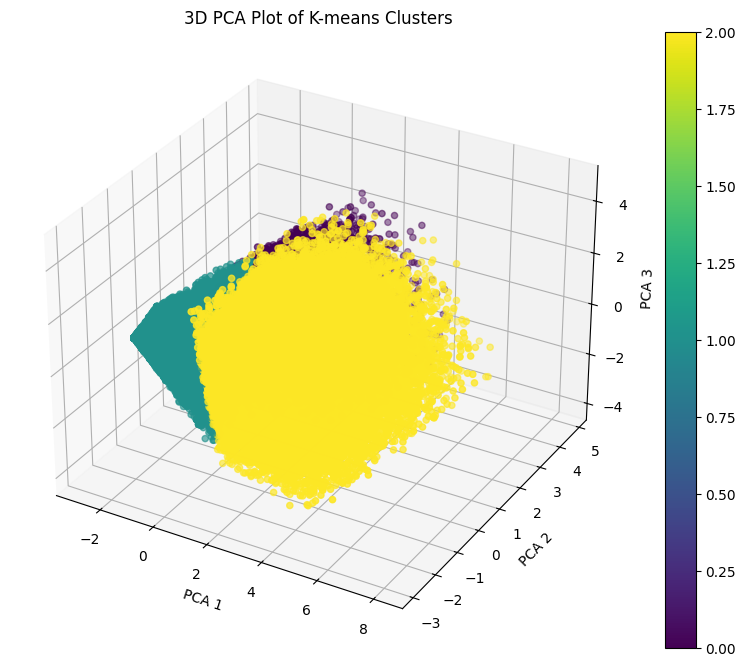

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_nutrition)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='viridis', s=20)
ax.set_title('3D PCA Plot of K-means Clusters')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter)
plt.show()

C:\Users\dolin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


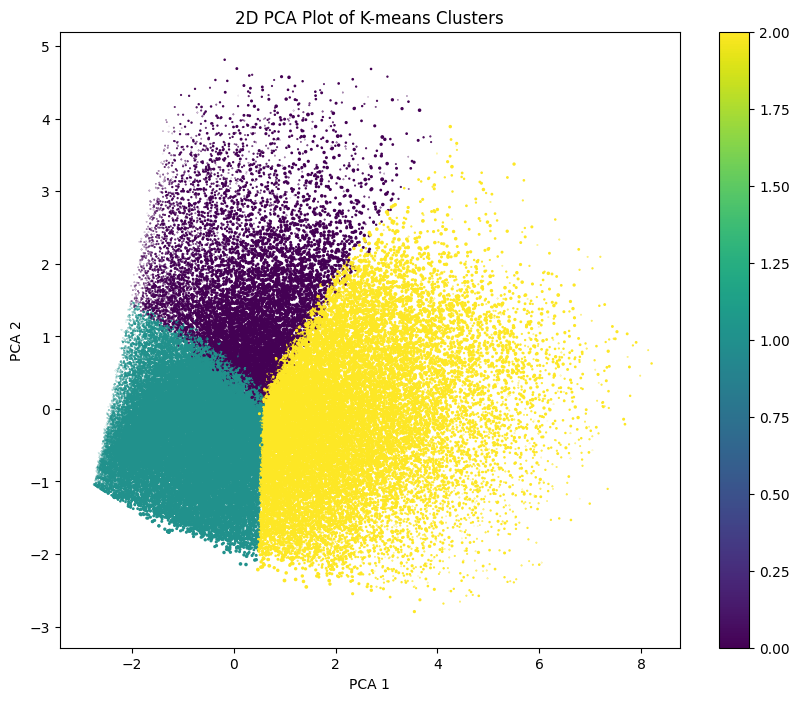

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='viridis')
ax.set_title('2D PCA Plot of K-means Clusters')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.colorbar(scatter)
plt.savefig('pca_2d.png')
plt.show()

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

def create_id_mappings(df, id_column):
    id_map = {}
    id_list = []
    for item_id in df[id_column].unique():
        id_map[item_id] = len(id_list)  # Map the id to the current index in the list
        id_list.append(item_id)  # Add the id to the list
    return id_list, id_map

In [30]:
# Take a sample of top 20000 users with the most reviews
top_users = reviews_filtered['user_id'].value_counts().head(1000).index
subset_reviews = reviews_filtered[reviews_filtered['user_id'].isin(top_users)]

In [31]:
user_ids, user_id_map = create_id_mappings(subset_reviews, 'user_id')
recipe_ids, recipe_id_map = create_id_mappings(subset_reviews, 'recipe_id')

n_users = len(user_ids)
n_recipes = len(recipe_ids)

In [32]:
# Create & populate list of row indices, col indices and ratings to construct csr
row_indices = []
col_indices = []
ratings = []

for _, row in subset_reviews.iterrows():
    user_index = user_id_map[row['user_id']]
    recipe_index = recipe_id_map[row['recipe_id']]
    row_indices.append(user_index)
    col_indices.append(recipe_index)
    ratings.append(row['rating'])

In [49]:
# Create user-item sparse matrix
user_item_sparse = csr_matrix((ratings, (row_indices, col_indices)), shape=(n_users, n_recipes))
user_item_sparse.shape

(1000, 166060)

In [34]:
# use nearestneighbors to calculate cosine sim
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model.fit(user_item_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [35]:
def recommend_recipes(user_id, num):
    if user_id not in user_id_map:
        print("User ID not found in the dataset.")
        return []

    # Get the internal index of the user
    user_index = user_id_map[user_id]
    
    # Find the top 10 most similar users to the target user
    distances, indices = model.kneighbors(user_item_sparse[user_index], n_neighbors=10)
    
    # Aggregate ratings from the most similar users
    similar_users = indices.flatten()
    recommended_recipes = {}
    for similar_user_index in similar_users:
        # Get recipes rated by the similar user
        similar_user_ratings = user_item_sparse[similar_user_index].toarray().flatten()
        
        for recipe_index, rating in enumerate(similar_user_ratings):
            if rating > 0 and recipe_index not in recommended_recipes:
                recommended_recipes[recipe_index] = rating

    # Sort recipes by the highest rating and select the top recommendations
    sorted_recipes = sorted(recommended_recipes, key=recommended_recipes.get, reverse=True)
    top_recipe_indices = sorted_recipes[:num]
    
    # Map recipe indices back to recipe IDs
    top_recipe_ids = [recipe_ids[recipe_index] for recipe_index in top_recipe_indices]
    return top_recipe_ids

In [36]:
user_id = top_users[0]
recommendations = recommend_recipes(user_id, 10)
print(recommendations)
true_recipes = reviews_filtered[reviews_filtered['user_id'] == user_id]['recipe_id']
true_recipes = list(true_recipes)
matched_recipes = [rec for rec in recommendations if rec in true_recipes]
precision = precision_score(matched_recipes, recommendations, average='macro')
precision

[256416, 408997, 426090, 175614, 383271, 174219, 257453, 348112, 411350, 99672]


1.0

In [38]:
def calculate_precision_recall(reviews_filtered, user_id_map, recipe_id_map, recipe_ids, model, num_recommendations=50):
    train_data, test_data = train_test_split(reviews_filtered, test_size=0.2, random_state=42)

    train_row_indices = []
    train_col_indices = []
    train_ratings = []

    for _, row in train_data.iterrows():
        user_index = user_id_map[row['user_id']]
        recipe_index = recipe_id_map[row['recipe_id']]
        train_row_indices.append(user_index)
        train_col_indices.append(recipe_index)
        train_ratings.append(row['rating'])

    train_sparse_matrix = csr_matrix((train_ratings, (train_row_indices, train_col_indices)),
                                      shape=(len(user_id_map), len(recipe_id_map)))   
    model.fit(train_sparse_matrix)

    precision_scores = []
    recall_scores = []

    for user_id in test_data['user_id'].unique():
        test_recipes = list(test_data[test_data['user_id'] == user_id]['recipe_id'])
       
        recommended_recipes = recommend_recipes(user_id, num_recommendations)
        matched_recipes = [rec for rec in recommended_recipes if rec in test_recipes]
        
        precision = len(matched_recipes) / num_recommendations
        recall = len(matched_recipes) / len(test_recipes) if len(test_recipes) > 0 else 0
        
        precision_scores.append(precision)
        recall_scores.append(recall)
   
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
   
    return avg_precision, avg_recall

precision, recall = calculate_precision_recall(
    subset_reviews, user_id_map, recipe_id_map, recipe_ids, model, num_recommendations=50
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

KeyboardInterrupt: 

In [99]:
recipes_filtered['content'] = recipes_filtered['ingredients'].fillna('') + ' ' + recipes_filtered['tags'].fillna('') + ' ' + recipes_filtered['name'].fillna('') + ' ' + recipes_filtered['description'].fillna('') + ' '
vectorizer = TfidfVectorizer(stop_words='english')
recipe_matrix = vectorizer.fit_transform(recipes_filtered['content'])

In [100]:
pos = reviews_filtered[reviews_filtered['rating'] >= 4]
user_content = pos.merge(recipes_filtered[['recipe_id', 'content']], on='recipe_id')
user_profiles = user_content.groupby('user_id')['content'].apply(lambda x: ' '.join(x))
user_profiles = user_profiles.reset_index().head(1000)
print(user_profiles)

     user_id                                            content
0       1533  ['tilapia fillets', 'egg white', 'flour', 'lem...
1       1535  ['hot dog', 'ketchup'] ['15-minutes-or-less', ...
2       1634  ['vegetable oil', 'onion', 'long grain white r...
3       1676  ['avocados', 'lime, juice of', 'tomatoes', 'on...
4       1755  ['pork sausage', 'flour', 'milk', 'pepper', 'p...
..       ...                                                ...
995    20361  ['butter', 'fresh mushrooms', 'onion', 'bonele...
996    20364  ['flour', 'milk', 'eggs', 'fat'] ['15-minutes-...
997    20365  ['instant tea powder', 'sugar-free orange drin...
998    20371  ['garlic', 'anchovy fillets', 'egg yolks', 'wh...
999    20375  ['olive oil', 'onion', 'garlic', 'red pepper',...

[1000 rows x 2 columns]


In [101]:
user_profile_matrix = vectorizer.transform(user_profiles['content'])

In [102]:
similarity_matrix = cosine_similarity(user_profile_matrix, recipe_matrix)

def content_based(user_id, top_n=10):
    user_index = user_profiles[user_profiles['user_id'] == user_id].index[0]    
    user_similarities = similarity_matrix[user_index]
    similar_recipes_indices = user_similarities.argsort()[::-1][:top_n]    
    recommended_recipe_ids = recipes_filtered.iloc[similar_recipes_indices]['recipe_id'].values
    return recommended_recipe_ids

In [64]:
user_id = 1535
recommendations = content_based(user_id, top_n=10)
print("Recommended recipes for user {}: {}".format(user_id, recommendations))
print(recipes_filtered[recipes_filtered['recipe_id'].isin(recommendations)])
print(reviews_filtered[reviews_filtered['user_id'] == user_id].head(10))

Recommended recipes for user 1535: [ 30750 249406  10584 225394 110923 139891 124856  24149  50402 141102]
                                         name  recipe_id  minutes  \
4372                  amanda s cinnamon toast      24149        4   
7579                   apple cinnamon squares     249406       40   
26367                blueberry yogurt muffins     124856       30   
82461                              fast fries     139891       12   
86868          fresh fruit breakfast parfaits     110923        5   
93960      golden puffs with honey butter dip     225394       35   
94199                  good ol  aussie damper      50402       11   
108628                       hot banana glory      30750       32   
204068  super easy fudgy mini chocolate cakes     141102       22   
219965                  unemployment potatoes      10584       47   

        contributor_id   submitted  \
4372             18108  2002-04-02   
7579             89831  2007-08-28   
26367            28

In [89]:
user_id_recipes = reviews_filtered[reviews_filtered['user_id'] == user_id]
user_id_recipes = user_id_recipes[user_id_recipes['rating'] == 5]
list(user_id_recipes['recipe_id'])
print(recipes_filtered[recipes_filtered['recipe_id'].isin(list(user_id_recipes['recipe_id']))].head(30))

                                                    name  recipe_id  minutes  \
430               it s that easy  graham cracker delight     328250        2   
602                                    get up   go  bars      63131       10   
733                                    0 point soup   ww     391705       55   
1082              2  handed kitchen sink tomato sandwich      77497       15   
1357                              30 minute baked potato     155496       25   
1384                                  30 second sandwich       9518        2   
1692          6 week bran muffins  auntie anne s muffins     190918       40   
1841                                    a   w cream soda     174369        5   
3902                               almond salad dressing     104353       10   
4015                       almond walnut coconut granola      63947       30   
4451                                     amaretto coffee     147441        5   
5065                       amy p s black

In [91]:
recipe = recipes_filtered[recipes_filtered['recipe_id'] == 185641]
for i in recipe['tags']:
    print(i)

['time-to-make', 'course', 'preparation', 'for-large-groups', 'breads', 'easy', 'coffee-cakes', 'dietary', 'number-of-servings', '4-hours-or-less']


In [103]:
train_reviews, test_reviews = train_test_split(pos, test_size=0.2, random_state=42)

train_pos = train_reviews[train_reviews['rating'] >= 4]
user_content_train = train_pos.merge(recipes_filtered[['recipe_id', 'content']], on='recipe_id')
user_profiles_train = user_content_train.groupby('user_id')['content'].apply(lambda x: ' '.join(x))
user_profiles_train = user_profiles_train.reset_index().head(500)
user_profile_matrix_train = vectorizer.transform(user_profiles_train['content'])
similarity_matrix_train = cosine_similarity(user_profile_matrix_train, recipe_matrix)
    
def content_based_train(user_id, top_n=10):
    user_row = user_profiles_train[user_profiles_train['user_id'] == user_id]
    if user_row.empty:
        return []
    user_index = user_row.index[0]
    user_similarities = similarity_matrix_train[user_index]
    similar_recipes_indices = user_similarities.argsort()[::-1][:top_n]
    recommended_recipe_ids = recipes_filtered.iloc[similar_recipes_indices]['recipe_id'].values
    return recommended_recipe_ids

def evaluate_user_content(user_id, train_reviews, test_reviews, top_n=10):
    train_high_rated = train_reviews[(train_reviews['user_id'] == user_id) & (train_reviews['rating'] >= 4)]['recipe_id'].values
    test_high_rated = set(test_reviews[(test_reviews['user_id'] == user_id) & (test_reviews['rating'] >= 4)]['recipe_id'].values)
    if len(train_high_rated) == 0 or len(test_high_rated) == 0:
        return None, None
    recommended_recipes = content_based_train(user_id, top_n)
    if len(recommended_recipes) == 0:
        return None, None
    true_positives = set(recommended_recipes) & test_high_rated
    precision = len(true_positives) / len(recommended_recipes) if len(recommended_recipes) > 0 else 0
    recall = len(true_positives) / len(test_high_rated) if len(test_high_rated) > 0 else 0
    return precision, recall

precision_scores = []
recall_scores = []

for user_id in test_reviews['user_id'].unique():
    precision, recall = evaluate_user_content(user_id, train_reviews, test_reviews, top_n=10)
    if precision is not None and recall is not None:
        precision_scores.append(precision)
        recall_scores.append(recall)

avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")

Average Precision: 0.0010
Average Recall: 0.0054
